In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("Librerías importadas correctamente ✓")

Librerías importadas correctamente ✓


In [2]:
# Cargar datos
df_eph = pd.read_parquet("../datos/processed/eph_consolidado.parquet")

# Filtrar solo CABA (32) y Mar del Plata (34)
aglomerados_seleccionados = [32, 34]
if 'AGLOMERADO' in df_eph.columns:
    df_eph = df_eph[df_eph['AGLOMERADO'].isin(aglomerados_seleccionados)].copy()
    print(f"✓ Filtrado: solo aglomerados {aglomerados_seleccionados} (CABA y Mar del Plata)")

print(f"Dataset cargado: {df_eph.shape}")

✓ Filtrado: solo aglomerados [32, 34] (CABA y Mar del Plata)
Dataset cargado: (54741, 251)


## 1. Análisis por Sexo

In [3]:
# Calcular tasas por sexo y período
df_pet = df_eph[df_eph['CH06'] >= 10].copy()

tasas_sexo = []

for periodo in sorted(df_pet['periodo'].unique()):
    for sexo in ['Varón', 'Mujer']:
        df_filtro = df_pet[(df_pet['periodo'] == periodo) & (df_pet['sexo'] == sexo)]
        
        pet = df_filtro['PONDERA'].sum()
        pea = df_filtro[df_filtro['es_pea']]['PONDERA'].sum()
        ocupados = df_filtro[df_filtro['es_ocupado']]['PONDERA'].sum()
        desocupados = df_filtro[df_filtro['es_desocupado']]['PONDERA'].sum()
        
        tasas_sexo.append({
            'periodo': periodo,
            'sexo': sexo,
            'tasa_actividad': (pea / pet) * 100 if pet > 0 else 0,
            'tasa_empleo': (ocupados / pet) * 100 if pet > 0 else 0,
            'tasa_desocupacion': (desocupados / pea) * 100 if pea > 0 else 0
        })

df_tasas_sexo = pd.DataFrame(tasas_sexo)
print("Tasas por sexo calculadas ✓")
df_tasas_sexo.head(10)

Tasas por sexo calculadas ✓


,periodo,sexo,tasa_actividad,tasa_empleo,tasa_desocupacion
0,2017-T2,Varón,67.67,62.64,7.44
1,2017-T2,Mujer,52.91,48.64,8.06
2,2017-T3,Varón,68.60,64.59,5.85
3,2017-T3,Mujer,52.35,47.46,9.35
4,2017-T4,Varón,69.81,65.77,5.78
5,2017-T4,Mujer,50.84,47.16,7.24
6,2018-T1,Varón,69.33,63.46,8.47
7,2018-T1,Mujer,53.19,48.54,8.74
8,2018-T2,Varón,67.45,62.90,6.75
9,2018-T2,Mujer,53.64,48.78,9.05


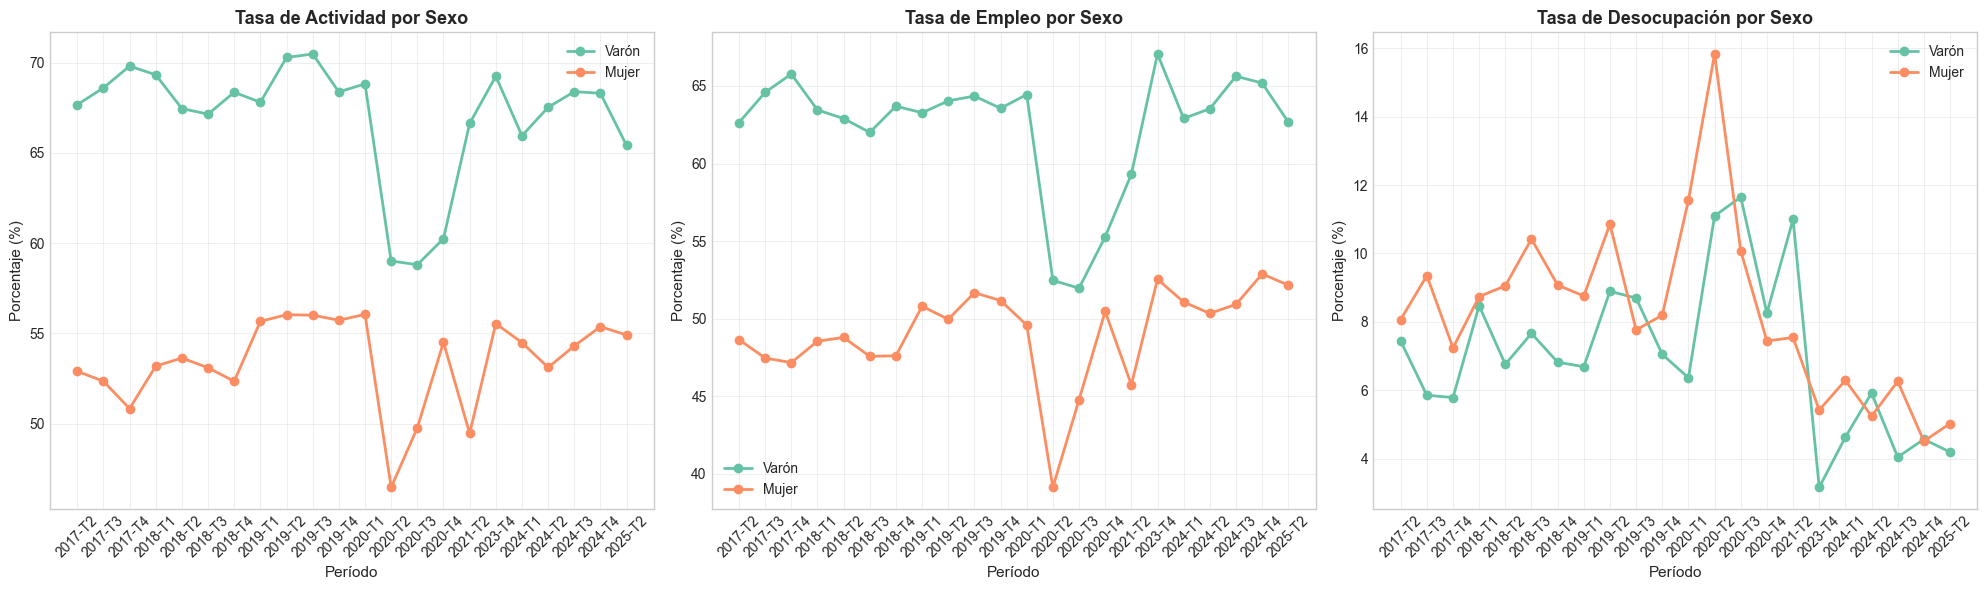

✓ Gráfico guardado: tasas_por_sexo.png


In [4]:
# Gráfico comparativo por sexo
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

indicadores = ['tasa_actividad', 'tasa_empleo', 'tasa_desocupacion']
titulos = ['Tasa de Actividad', 'Tasa de Empleo', 'Tasa de Desocupación']

for i, (indicador, titulo) in enumerate(zip(indicadores, titulos)):
    for sexo in ['Varón', 'Mujer']:
        df_plot = df_tasas_sexo[df_tasas_sexo['sexo'] == sexo]
        axes[i].plot(df_plot['periodo'], df_plot[indicador], 
                    marker='o', linewidth=2, label=sexo)
    
    axes[i].set_title(f'{titulo} por Sexo', fontsize=13, fontweight='bold')
    axes[i].set_xlabel('Período', fontsize=11)
    axes[i].set_ylabel('Porcentaje (%)', fontsize=11)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../resultados/graficos/tasas_por_sexo.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: tasas_por_sexo.png")

## 2. Análisis por Grupo de Edad

In [5]:
# Calcular tasas por grupo de edad (simplificado: jóvenes vs adultos)
df_pet = df_eph[df_eph['CH06'] >= 10].copy()
df_pet['grupo_edad_simple'] = df_pet['CH06'].apply(lambda x: 'Jóvenes (10-29)' if x < 30 else 'Adultos (30+)')

tasas_edad = []

for periodo in sorted(df_pet['periodo'].unique()):
    for grupo in ['Jóvenes (10-29)', 'Adultos (30+)']:
        df_filtro = df_pet[(df_pet['periodo'] == periodo) & (df_pet['grupo_edad_simple'] == grupo)]
        
        pet = df_filtro['PONDERA'].sum()
        pea = df_filtro[df_filtro['es_pea']]['PONDERA'].sum()
        ocupados = df_filtro[df_filtro['es_ocupado']]['PONDERA'].sum()
        desocupados = df_filtro[df_filtro['es_desocupado']]['PONDERA'].sum()
        
        tasas_edad.append({
            'periodo': periodo,
            'grupo_edad': grupo,
            'tasa_actividad': (pea / pet) * 100 if pet > 0 else 0,
            'tasa_empleo': (ocupados / pet) * 100 if pet > 0 else 0,
            'tasa_desocupacion': (desocupados / pea) * 100 if pea > 0 else 0
        })

df_tasas_edad = pd.DataFrame(tasas_edad)
print("Tasas por edad calculadas ✓")

Tasas por edad calculadas ✓


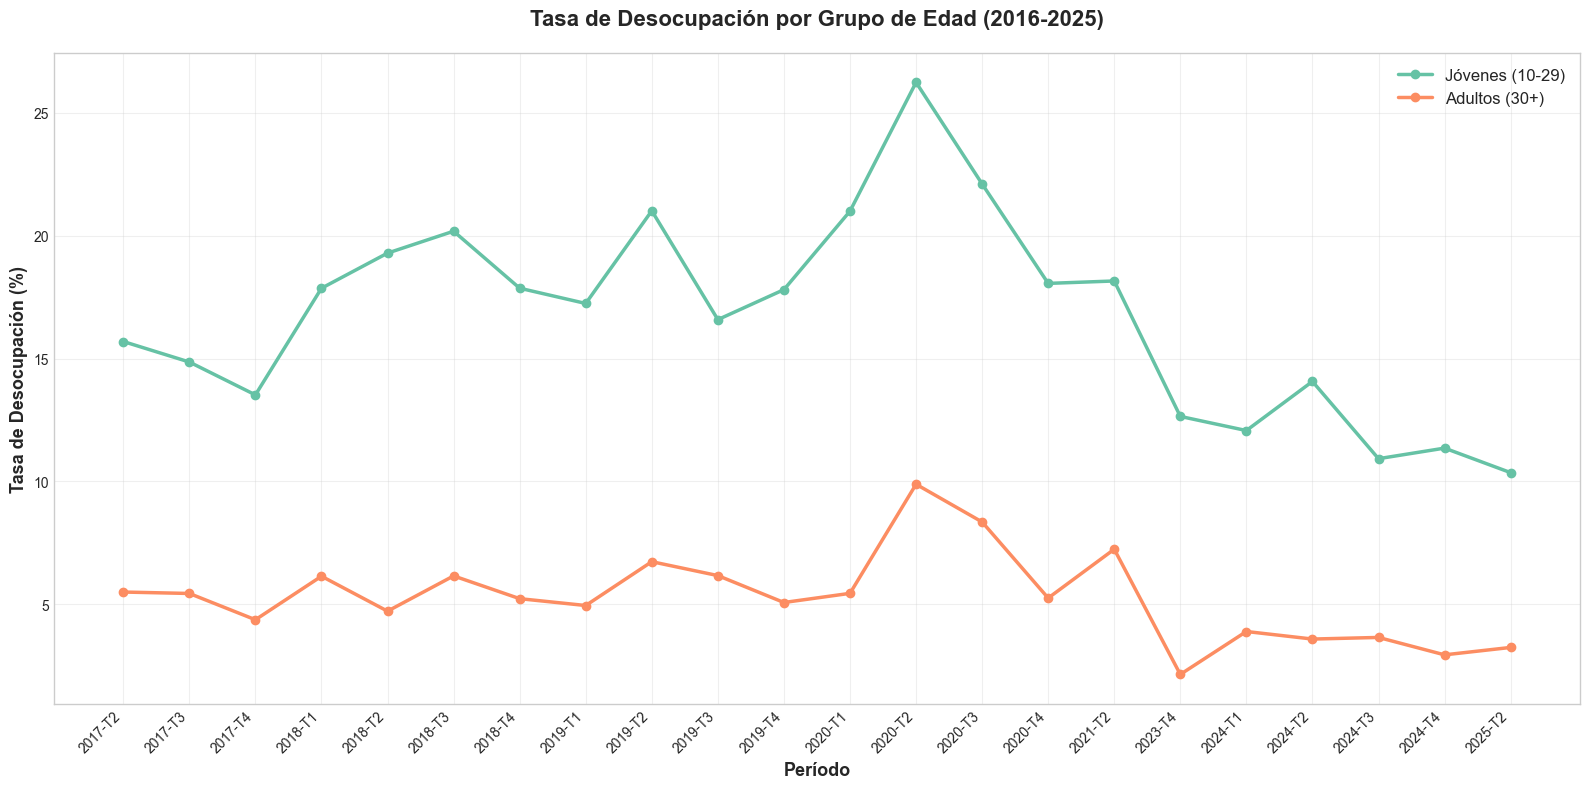

✓ Gráfico guardado: desocupacion_por_edad.png


In [6]:
# Gráfico: Tasa de desocupación por edad
fig, ax = plt.subplots(figsize=(16, 8))

for grupo in df_tasas_edad['grupo_edad'].unique():
    df_plot = df_tasas_edad[df_tasas_edad['grupo_edad'] == grupo]
    ax.plot(df_plot['periodo'], df_plot['tasa_desocupacion'], 
           marker='o', linewidth=2.5, markersize=6, label=grupo)

ax.set_title('Tasa de Desocupación por Grupo de Edad (2016-2025)', 
            fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Período', fontsize=13, fontweight='bold')
ax.set_ylabel('Tasa de Desocupación (%)', fontsize=13, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('../resultados/graficos/desocupacion_por_edad.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: desocupacion_por_edad.png")

## 3. Análisis de Ingresos por Sexo

In [7]:
# Calcular brecha de ingresos por sexo
columna_ingreso = 'P21_real' if 'P21_real' in df_eph.columns else 'P47T_real'

df_ocupados = df_eph[
    (df_eph['es_ocupado']) & 
    (df_eph[columna_ingreso].notna()) & 
    (df_eph[columna_ingreso] > 0)
].copy()

ingresos_sexo = []

for periodo in sorted(df_ocupados['periodo'].unique()):
    for sexo in ['Varón', 'Mujer']:
        df_filtro = df_ocupados[(df_ocupados['periodo'] == periodo) & (df_ocupados['sexo'] == sexo)]
        
        if len(df_filtro) > 0:
            ingreso_medio = np.average(df_filtro[columna_ingreso], weights=df_filtro['PONDERA'])
            
            ingresos_sexo.append({
                'periodo': periodo,
                'sexo': sexo,
                'ingreso_medio': ingreso_medio
            })

df_ingresos_sexo = pd.DataFrame(ingresos_sexo)
print("Ingresos por sexo calculados ✓")

Ingresos por sexo calculados ✓


In [8]:
# Calcular brecha salarial de género
df_varon = df_ingresos_sexo[df_ingresos_sexo['sexo'] == 'Varón'][['periodo', 'ingreso_medio']].rename(columns={'ingreso_medio': 'ingreso_varon'})
df_mujer = df_ingresos_sexo[df_ingresos_sexo['sexo'] == 'Mujer'][['periodo', 'ingreso_medio']].rename(columns={'ingreso_medio': 'ingreso_mujer'})

df_brecha = df_varon.merge(df_mujer, on='periodo')
df_brecha['brecha_porcentual'] = ((df_brecha['ingreso_varon'] - df_brecha['ingreso_mujer']) / df_brecha['ingreso_varon']) * 100

print(f"Brecha salarial promedio: {df_brecha['brecha_porcentual'].mean():.2f}%")
print(f"\nPrimeros períodos:")
df_brecha.head(10)

Brecha salarial promedio: 23.89%

Primeros períodos:


,periodo,ingreso_varon,ingreso_mujer,brecha_porcentual
0,2017-T2,452698.22,322389.82,28.78
1,2017-T3,467880.17,335673.66,28.26
2,2017-T4,454858.33,353553.27,22.27
3,2018-T1,467521.12,368422.45,21.20
4,2018-T2,421325.36,331039.46,21.43
5,2018-T3,399343.80,296295.39,25.80
6,2018-T4,380736.38,299280.23,21.39
7,2019-T1,409583.44,289467.35,29.33
8,2019-T2,399980.07,305796.25,23.55
9,2019-T3,406424.41,293343.80,27.82


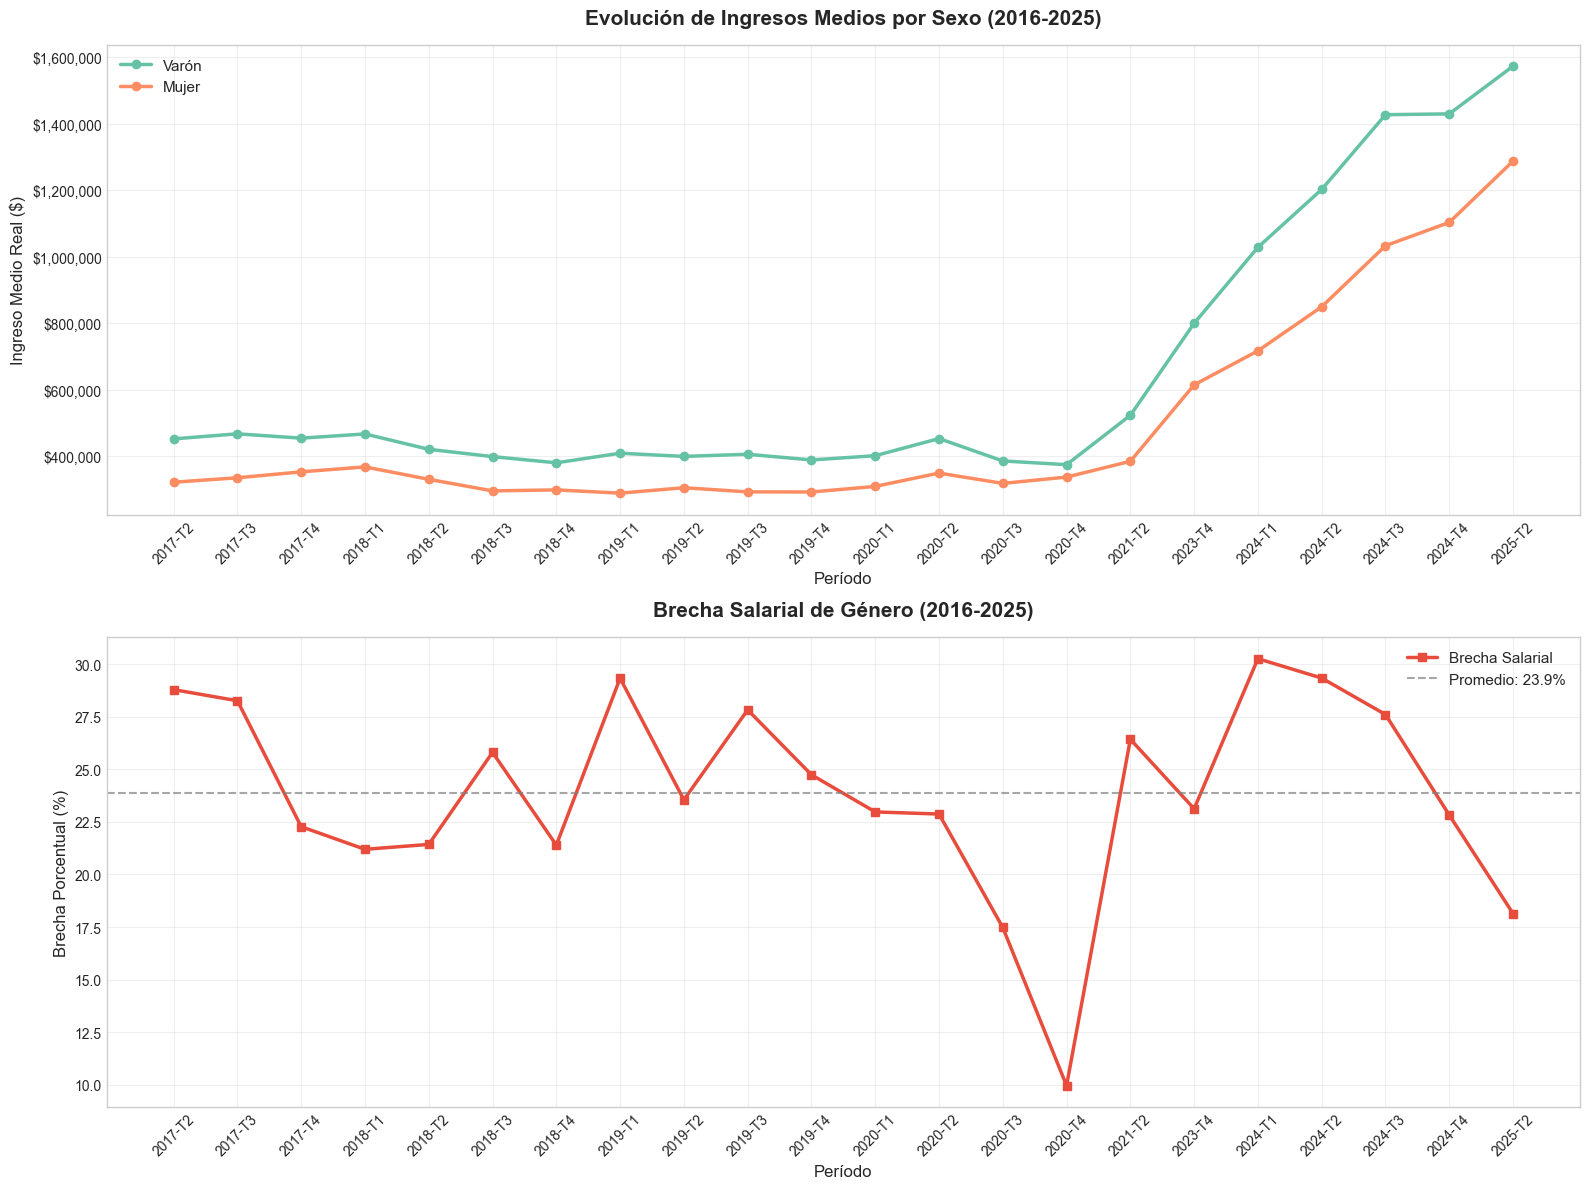

✓ Gráfico guardado: ingresos_brecha_genero.png


In [9]:
# Gráfico de ingresos por sexo y brecha
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Subplot 1: Ingresos medios
for sexo in ['Varón', 'Mujer']:
    df_plot = df_ingresos_sexo[df_ingresos_sexo['sexo'] == sexo]
    ax1.plot(df_plot['periodo'], df_plot['ingreso_medio'], 
            marker='o', linewidth=2.5, markersize=6, label=sexo)

ax1.set_title('Evolución de Ingresos Medios por Sexo (2016-2025)', 
             fontsize=15, fontweight='bold', pad=15)
ax1.set_xlabel('Período', fontsize=12)
ax1.set_ylabel('Ingreso Medio Real ($)', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Subplot 2: Brecha salarial
ax2.plot(df_brecha['periodo'], df_brecha['brecha_porcentual'], 
        marker='s', linewidth=2.5, markersize=6, color='#e74c3c', label='Brecha Salarial')
ax2.axhline(y=df_brecha['brecha_porcentual'].mean(), color='gray', 
           linestyle='--', linewidth=1.5, alpha=0.7, 
           label=f"Promedio: {df_brecha['brecha_porcentual'].mean():.1f}%")

ax2.set_title('Brecha Salarial de Género (2016-2025)', 
             fontsize=15, fontweight='bold', pad=15)
ax2.set_xlabel('Período', fontsize=12)
ax2.set_ylabel('Brecha Porcentual (%)', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

for ax in [ax1, ax2]:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../resultados/graficos/ingresos_brecha_genero.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: ingresos_brecha_genero.png")

## 4. Comparación entre CABA y Mar del Plata

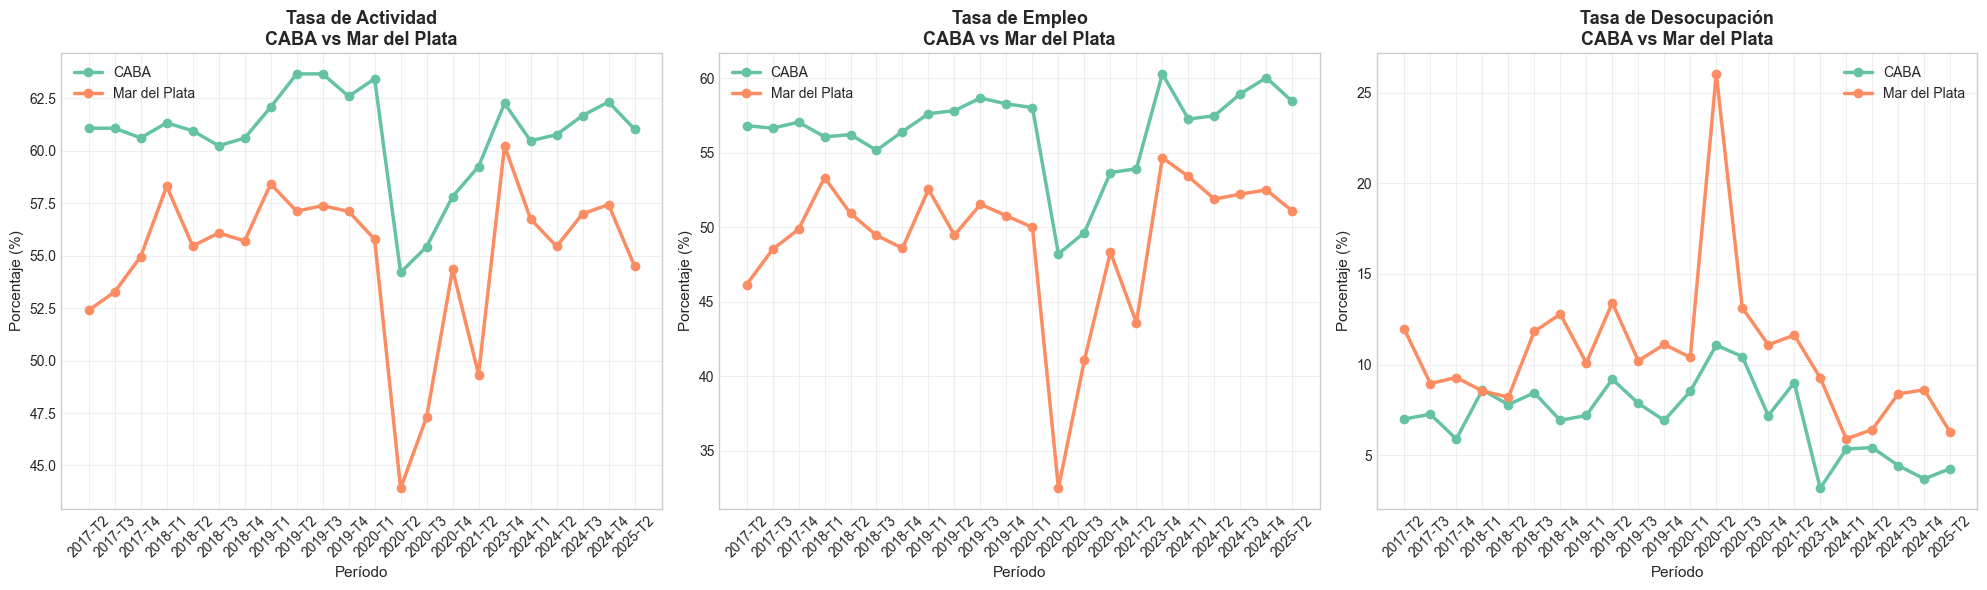

✓ Análisis comparativo CABA vs Mar del Plata completado
✓ Gráfico guardado: comparacion_caba_mdq.png


In [10]:
# Análisis comparativo entre CABA (32) y Mar del Plata (34)
if 'AGLOMERADO' in df_eph.columns:
    aglomerados_comparar = {
        32: 'CABA',
        34: 'Mar del Plata'
    }
    
    df_pet = df_eph[df_eph['CH06'] >= 10].copy()
    
    tasas_aglom_comp = []
    
    for periodo in sorted(df_pet['periodo'].unique()):
        for cod_aglom, nombre in aglomerados_comparar.items():
            df_filtro = df_pet[(df_pet['periodo'] == periodo) & (df_pet['AGLOMERADO'] == cod_aglom)]
            
            if len(df_filtro) > 0:
                pet = df_filtro['PONDERA'].sum()
                pea = df_filtro[df_filtro['es_pea']]['PONDERA'].sum()
                ocupados = df_filtro[df_filtro['es_ocupado']]['PONDERA'].sum()
                desocupados = df_filtro[df_filtro['es_desocupado']]['PONDERA'].sum()
                
                tasas_aglom_comp.append({
                    'periodo': periodo,
                    'aglomerado': nombre,
                    'tasa_actividad': (pea / pet) * 100 if pet > 0 else 0,
                    'tasa_empleo': (ocupados / pet) * 100 if pet > 0 else 0,
                    'tasa_desocupacion': (desocupados / pea) * 100 if pea > 0 else 0
                })
    
    df_tasas_comp = pd.DataFrame(tasas_aglom_comp)
    
    # Gráfico comparativo
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    indicadores = ['tasa_actividad', 'tasa_empleo', 'tasa_desocupacion']
    titulos = ['Tasa de Actividad', 'Tasa de Empleo', 'Tasa de Desocupación']
    
    for i, (indicador, titulo) in enumerate(zip(indicadores, titulos)):
        for aglom in ['CABA', 'Mar del Plata']:
            df_plot = df_tasas_comp[df_tasas_comp['aglomerado'] == aglom]
            axes[i].plot(df_plot['periodo'], df_plot[indicador], 
                        marker='o', linewidth=2.5, markersize=6, label=aglom)
        
        axes[i].set_title(f'{titulo}\nCABA vs Mar del Plata', fontsize=13, fontweight='bold')
        axes[i].set_xlabel('Período', fontsize=11)
        axes[i].set_ylabel('Porcentaje (%)', fontsize=11)
        axes[i].legend(fontsize=10)
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('../resultados/graficos/comparacion_caba_mdq.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Análisis comparativo CABA vs Mar del Plata completado")
    print("✓ Gráfico guardado: comparacion_caba_mdq.png")
else:
    print("⚠️ Columna AGLOMERADO no disponible")

## 5. Análisis por Nivel Educativo

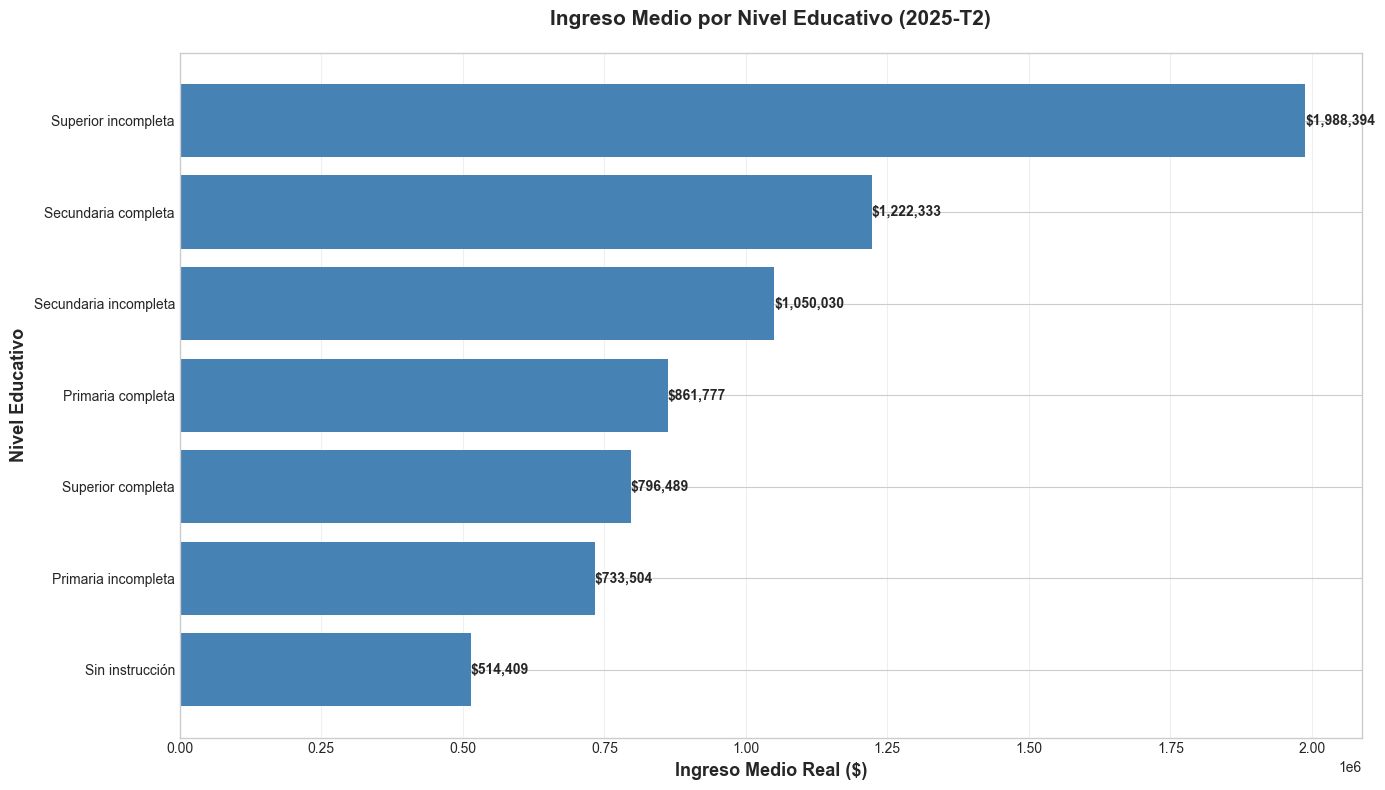

✓ Gráfico guardado: ingresos_nivel_educativo.png


In [11]:
# Analizar ingresos por nivel educativo
if 'NIVEL_ED' in df_ocupados.columns:
    # Mapeo de códigos de nivel educativo (aproximado)
    mapeo_educacion = {
        1: 'Sin instrucción',
        2: 'Primaria incompleta',
        3: 'Primaria completa',
        4: 'Secundaria incompleta',
        5: 'Secundaria completa',
        6: 'Superior incompleta',
        7: 'Superior completa'
    }
    
    df_ocupados['nivel_ed_desc'] = df_ocupados['NIVEL_ED'].map(mapeo_educacion)
    
    # Calcular ingreso medio por nivel educativo (último año disponible)
    ultimo_periodo = df_ocupados['periodo'].max()
    df_ultimo = df_ocupados[df_ocupados['periodo'] == ultimo_periodo]
    
    ingresos_educacion = []
    
    for nivel in df_ultimo['nivel_ed_desc'].dropna().unique():
        df_nivel = df_ultimo[df_ultimo['nivel_ed_desc'] == nivel]
        if len(df_nivel) > 0:
            ingreso = np.average(df_nivel[columna_ingreso], weights=df_nivel['PONDERA'])
            ingresos_educacion.append({
                'nivel_educativo': nivel,
                'ingreso_medio': ingreso,
                'n_casos': len(df_nivel)
            })
    
    df_ing_ed = pd.DataFrame(ingresos_educacion).sort_values('ingreso_medio')
    
    # Gráfico de barras
    fig, ax = plt.subplots(figsize=(14, 8))
    
    bars = ax.barh(df_ing_ed['nivel_educativo'], df_ing_ed['ingreso_medio'], color='steelblue')
    
    ax.set_xlabel('Ingreso Medio Real ($)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Nivel Educativo', fontsize=13, fontweight='bold')
    ax.set_title(f'Ingreso Medio por Nivel Educativo ({ultimo_periodo})', 
                fontsize=15, fontweight='bold', pad=20)
    
    # Agregar valores en las barras
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, 
               f'${width:,.0f}', ha='left', va='center', fontsize=10, fontweight='bold')
    
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    
    plt.savefig('../resultados/graficos/ingresos_nivel_educativo.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Gráfico guardado: ingresos_nivel_educativo.png")
else:
    print("Variable NIVEL_ED no disponible en el dataset")

## 5. Heatmap de Correlaciones

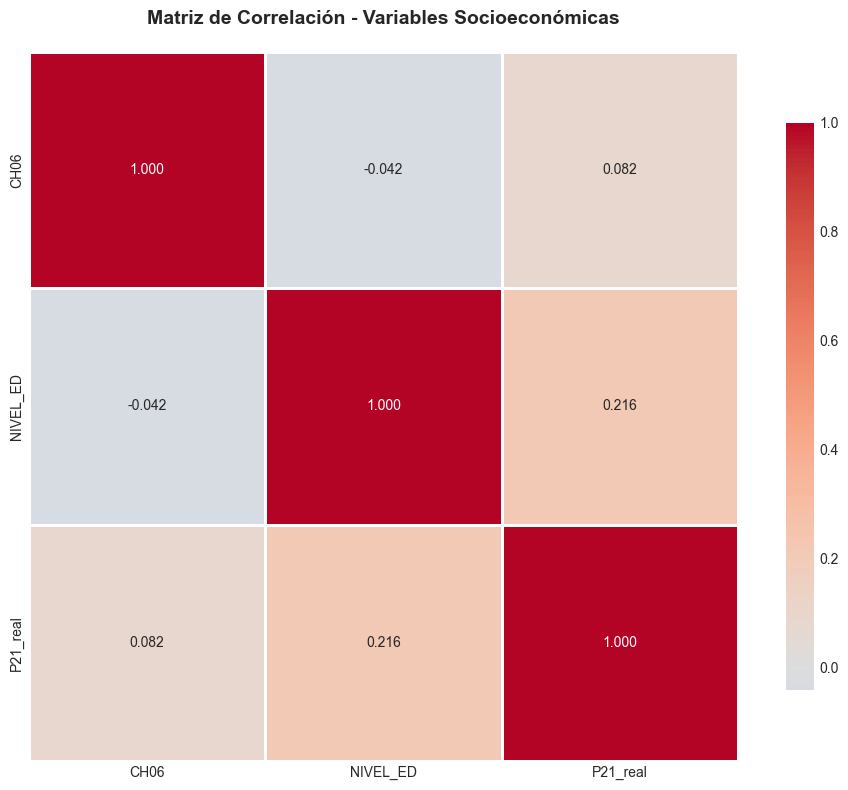

✓ Gráfico guardado: correlaciones.png


In [12]:
# Crear dataset para correlaciones
variables_numericas = ['CH06', 'NIVEL_ED']
if columna_ingreso in df_ocupados.columns:
    variables_numericas.append(columna_ingreso)

# Filtrar solo variables que existan
variables_disponibles = [v for v in variables_numericas if v in df_ocupados.columns]

if len(variables_disponibles) >= 2:
    df_corr = df_ocupados[variables_disponibles].corr()
    
    # Gráfico de correlaciones
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(df_corr, annot=True, fmt='.3f', cmap='coolwarm', 
               center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    
    ax.set_title('Matriz de Correlación - Variables Socioeconómicas', 
                fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig('../resultados/graficos/correlaciones.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Gráfico guardado: correlaciones.png")
else:
    print("No hay suficientes variables numéricas para calcular correlaciones")

## 6. Guardar Resultados

In [13]:
# Guardar tablas de análisis multivariado
df_tasas_sexo.to_csv('../resultados/tablas/tasas_por_sexo.csv', index=False)
df_tasas_edad.to_csv('../resultados/tablas/tasas_por_edad.csv', index=False)
df_brecha.to_csv('../resultados/tablas/brecha_salarial.csv', index=False)

print("✓ Tablas guardadas:")
print("  • tasas_por_sexo.csv")
print("  • tasas_por_edad.csv")
print("  • brecha_salarial.csv")

✓ Tablas guardadas:
  • tasas_por_sexo.csv
  • tasas_por_edad.csv
  • brecha_salarial.csv


## 7. Resumen del Análisis Multivariado

In [14]:
print("="*70)
print("RESUMEN DEL ANÁLISIS MULTIVARIADO")
print("="*70)

print("\n1. DIFERENCIAS POR SEXO")
desoc_varon = df_tasas_sexo[df_tasas_sexo['sexo'] == 'Varón']['tasa_desocupacion'].mean()
desoc_mujer = df_tasas_sexo[df_tasas_sexo['sexo'] == 'Mujer']['tasa_desocupacion'].mean()
print(f"   Tasa desocupación promedio - Varones: {desoc_varon:.2f}%")
print(f"   Tasa desocupación promedio - Mujeres: {desoc_mujer:.2f}%")
print(f"   Brecha salarial promedio: {df_brecha['brecha_porcentual'].mean():.2f}%")

print("\n2. DIFERENCIAS POR EDAD")
desoc_jovenes = df_tasas_edad[df_tasas_edad['grupo_edad'] == 'Jóvenes (10-29)']['tasa_desocupacion'].mean()
desoc_adultos = df_tasas_edad[df_tasas_edad['grupo_edad'] == 'Adultos (30+)']['tasa_desocupacion'].mean()
print(f"   Tasa desocupación - Jóvenes: {desoc_jovenes:.2f}%")
print(f"   Tasa desocupación - Adultos: {desoc_adultos:.2f}%")

print(f"\n{'='*70}")
print("Análisis multivariado completado ✓")
print(f"{'='*70}")

RESUMEN DEL ANÁLISIS MULTIVARIADO

1. DIFERENCIAS POR SEXO
   Tasa desocupación promedio - Varones: 7.04%
   Tasa desocupación promedio - Mujeres: 8.30%
   Brecha salarial promedio: 23.89%

2. DIFERENCIAS POR EDAD
   Tasa desocupación - Jóvenes: 16.77%
   Tasa desocupación - Adultos: 5.27%

Análisis multivariado completado ✓
